In [15]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt


In [16]:
import os
import pandas as pd
import re
import numpy as np
import glob
from pathlib import Path
from scipy import sparse
from copy import deepcopy
import pickle
import seaborn as sns
from scipy.stats import mannwhitneyu
from itertools import combinations

<h3> Load data </h3>

In [17]:
out_dir = '../out.myeloid.060121/'

In [18]:
### Can be downloaded at https://data.humantumoratlas.org/
adata = sc.read(out_dir + 'adata.myeloid.010920.h5ad')


Only considering the two last: ['.010920', '.h5ad'].
Only considering the two last: ['.010920', '.h5ad'].


In [19]:
sclc_dir = '../out.myeloid.SCLC_samples_only.060121/'

In [21]:
### Can be downloaded at https://data.humantumoratlas.org/
adata_sclc = sc.read(sclc_dir + 'adata.myeloid.SCLC_samples_only.010920.h5ad')


Only considering the two last: ['.010920', '.h5ad'].
Only considering the two last: ['.010920', '.h5ad'].


### Figure 6E

In [22]:
adata_MoMf = adata[adata.obs['cell_type'].isin(['Mo/Mφ'])]
adata_MoMf.obs['fibrotic_Mo/Mφ'] = (adata_MoMf.obs['clusters']=='6').astype(bool)

Trying to set attribute `.obs` of view, copying.


In [23]:
tally_df = adata_MoMf.obs.loc[:,['batch','fibrotic_Mo/Mφ']].groupby(['batch','fibrotic_Mo/Mφ']).size().reset_index()
tally_df = tally_df.pivot(index = 'batch', columns = 'fibrotic_Mo/Mφ')
tally_df.columns = tally_df.columns.droplevel(0)
proportions_fibrotic_momf = tally_df.div(tally_df.sum(axis=1), axis=0)*100

In [24]:
sample_annotations = adata_MoMf.obs.loc[:,['batch','treatment','histo_tissue']]
sample_annotations = sample_annotations.loc[~sample_annotations.duplicated(),:].set_index('batch')

In [25]:
proportions_fibrotic_momf.loc[:,'treatment'] = sample_annotations.loc[proportions_fibrotic_momf.index,
                                                                      'treatment']
proportions_fibrotic_momf.loc[:,'histo_tissue'] = sample_annotations.loc[proportions_fibrotic_momf.index,
                                                                      'histo_tissue']


In [26]:
histo_colormap = {'normal':'tab:brown',
                  'normal_lung':'tab:brown',
                 'LUAD':'tab:purple',
                 'LUAD_lung':'tab:purple',
                 'LUAD_met':'tab:gray',
                 'LUAD_metastatic':'tab:gray',
                 'SCLC':'tab:blue',
                 'SCLC_met':'tab:blue',
                 'SCLC_metastatic':'tab:blue',
                 'SCLC_lung':'tab:cyan'}

In [27]:
proportions_fibrotic_momf = proportions_fibrotic_momf.loc[~proportions_fibrotic_momf.index.str.contains('Bambanker'),:]

In [28]:
proportions_fibrotic_momf = proportions_fibrotic_momf.loc[~proportions_fibrotic_momf.index.str.contains('1170g$|1170g_S'),:]

In [29]:
tmp = adata.obs.loc[:,['batch','patient']]
tmp = tmp.loc[~tmp.batch.duplicated(),:]
tmp.index = tmp.batch
tmp = tmp.patient
proportions_fibrotic_momf.loc[:,'patient'] = tmp.loc[proportions_fibrotic_momf.index]

In [30]:
proportions_fibrotic_momf.loc[:,'matched'] = proportions_fibrotic_momf.patient.astype(str)

In [31]:
unmatched = proportions_fibrotic_momf.patient.value_counts()
unmatched = unmatched.index[unmatched==1]

In [32]:
proportions_fibrotic_momf.loc[proportions_fibrotic_momf.patient.isin(unmatched),'matched'] = 'Unmatched'

In [33]:
order = ['Unmatched','RU1144','RU1181','RU1134', 'RU675', 'RU682', 'RU684']
proportions_fibrotic_momf.loc[:,'matched'] = proportions_fibrotic_momf.matched.astype('category').cat.reorder_categories(order)

In [34]:
for i,j in combinations(proportions_fibrotic_momf.histo_tissue.cat.categories,2):
    group1 = proportions_fibrotic_momf.loc[proportions_fibrotic_momf.histo_tissue==i,True]
    group2 = proportions_fibrotic_momf.loc[proportions_fibrotic_momf.histo_tissue==j,True]
    
    if sum(group1) == 0 and sum(group2) == 0:
        print(i,j,1)
    else:
        tmp = mannwhitneyu(group1, group2)
        print(i,j,tmp.pvalue)

LUAD_lung LUAD_met 0.11155092752514184
LUAD_lung SCLC_lung 0.16961861067292622
LUAD_lung SCLC_met 0.004672007828229457
LUAD_lung normal 0.16362599107014164
LUAD_met SCLC_lung 0.04098690243436179
LUAD_met SCLC_met 0.0019196126933133826
LUAD_met normal 1
SCLC_lung SCLC_met 0.11613659414077632
SCLC_lung normal 0.07875601404859744
SCLC_met normal 0.0075904611724833876


/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


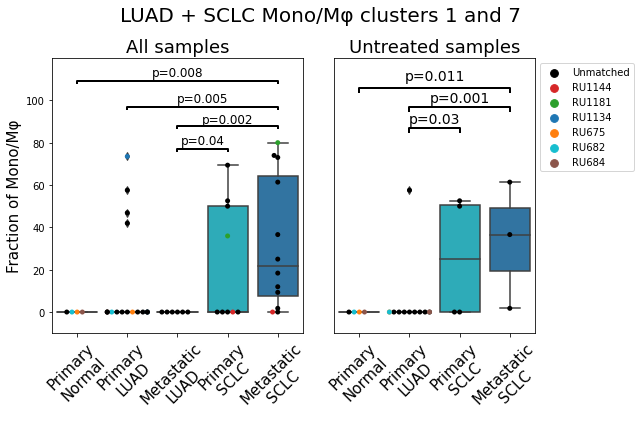

In [35]:
# all samples
fig, axes = plt.subplots(1,2, figsize = [9,6], gridspec_kw={'width_ratios': [1.25, 1]})

ax = axes[0]
sns.boxplot(y = True, x = 'histo_tissue', data = proportions_fibrotic_momf, 
           order = ['normal','LUAD_lung','LUAD_met','SCLC_lung','SCLC_met'], palette = histo_colormap,ax=ax,
           )
sns.swarmplot(y = True, x = 'histo_tissue', data = proportions_fibrotic_momf,
           order = ['normal','LUAD_lung','LUAD_met','SCLC_lung','SCLC_met'], 
              hue = 'matched',
              palette = ['black','tab:red','tab:green','tab:blue','tab:orange','tab:cyan','tab:brown'],ax=ax,
             )
ax.set_ylabel('Fraction of Mono/Mφ', fontsize = 16)
ax.set_title('All samples', fontsize = 18)
ax.set_xticklabels(['Primary\nNormal','Primary\nLUAD','Metastatic\nLUAD','Primary\nSCLC','Metastatic\nSCLC'],
           rotation=45, 
           fontsize = 15)
ax.set_ylabel('Fraction of Mono/Mφ',fontsize = 15)
ax.set_xlabel('')

ax.set_ylim(-10,119.9)
ax.plot([2,2,3,3], [76, 77, 77, 76], lw=2, c='black')
ax.plot([2,2,4,4], [87, 88, 88, 87], lw=2, c='black')
ax.plot([0,0,4,4], [108, 109, 109, 108], lw=2, c='black')
ax.plot([1,1,4,4], [96, 97, 97, 96], lw=2, c='black')

ax.text(2., 110, 'p=0.008', ha='center', va='bottom', color='black',fontsize = 12)
ax.text(2.5, 98, 'p=0.005', ha='center', va='bottom', color='black',fontsize = 12)
ax.text(3, 88, 'p=0.002', ha='center', va='bottom', color='black',fontsize = 12)
ax.text(2.5, 78, 'p=0.04', ha='center', va='bottom', color='black',fontsize = 12)
ax.get_legend().remove()

# naive only
ax = axes[1]
sns.boxplot(y = True, x = 'histo_tissue', 
            data = proportions_fibrotic_momf[proportions_fibrotic_momf['treatment']=='Naive'],
            order = ['normal','LUAD_lung','SCLC_lung','SCLC_met'], palette = histo_colormap,ax=ax
           )
sns.swarmplot(y = True, x = 'histo_tissue', 
              data = proportions_fibrotic_momf[proportions_fibrotic_momf['treatment']=='Naive'],
              order = ['normal','LUAD_lung','SCLC_lung','SCLC_met'], 
              hue = 'matched',
              palette = ['black','tab:red','tab:green','tab:blue','tab:orange','tab:cyan','tab:brown'],ax=ax
              #color = 'black'
             )
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))

ax.set_title('Untreated samples', fontsize = 18)
ax.set_xticklabels(['Primary\nNormal','Primary\nLUAD','Primary\nSCLC','Metastatic\nSCLC'],
           rotation=45, 
           fontsize = 15)
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-10,119.9)
ax.plot([1,1,2,2], [85, 87, 87, 85], lw=2, c='black')
ax.plot([0,0,3,3], [104, 106, 106, 104], lw=2, c='black')
ax.plot([1,1,3,3], [95, 97, 97, 95], lw=2, c='black')

ax.text(1.5, 108, 'p=0.011', ha='center', va='bottom', color='black',fontsize = 14)
ax.text(2, 98, 'p=0.001', ha='center', va='bottom', color='black',fontsize = 14)
ax.text(1.5, 88, 'p=0.03', ha='center', va='bottom', color='black',fontsize = 14)

plt.suptitle('LUAD + SCLC Mono/Mφ clusters 1 and 7', fontsize = 20)

plt.tight_layout()


### Figure S5A

In [36]:
import palettable

In [37]:
sc.set_figure_params(fontsize=16)

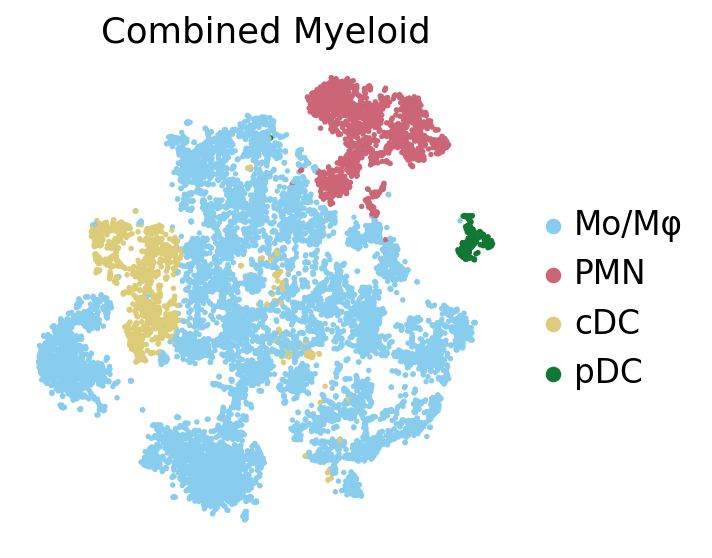

In [38]:
sc.pl.umap(
    adata, 
    color= 'cell_type',
    ncols=2, size=24,
    palette= palettable.cartocolors.qualitative.Safe_5.mpl_colors, 
    legend_fontoutline=2, title = 'Combined Myeloid' ,
    frameon=False
)

### Figure S7A

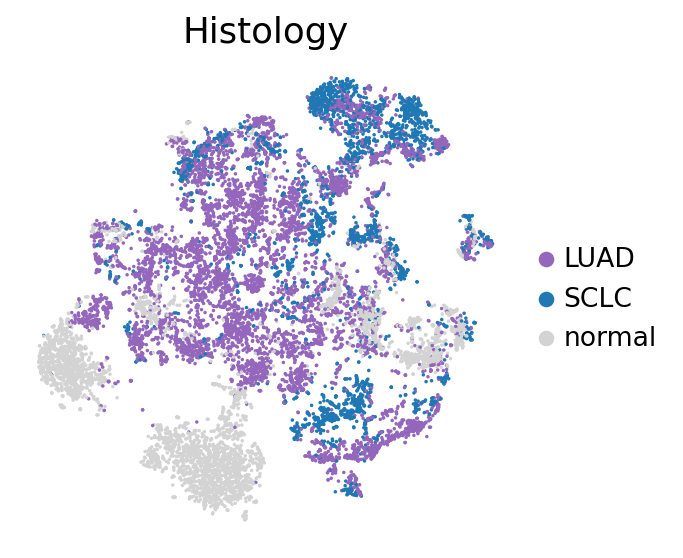

In [39]:
sc.pl.umap(
    adata, 
    color= ['histo'],
    ncols=2, size=10,
    palette = ['tab:purple','tab:blue','lightgray'],
    legend_fontsize=12, vmax = 3,
    legend_fontoutline=2, title = 'Histology',
    frameon=False
)

### Figure S7B

In [40]:
adata.obs.loc[:,'sclc_phenograph'] = ''
ind_cells = adata_sclc.obs.index[adata_sclc.obs.clusters.isin([1,7,9,12,2,4,6])] 
adata.obs.loc[ind_cells,'sclc_phenograph'] = adata_sclc.obs.loc[ind_cells,'clusters'].astype(str).values

In [45]:
adata.obs.sclc_phenograph = adata.obs.sclc_phenograph.astype('category') 

In [46]:
pal = ['lightgray' if i=='' else 'C' + str(int(i)+1) for i in adata.obs.sclc_phenograph.cat.categories]

In [47]:
sc.set_figure_params(fontsize=20)

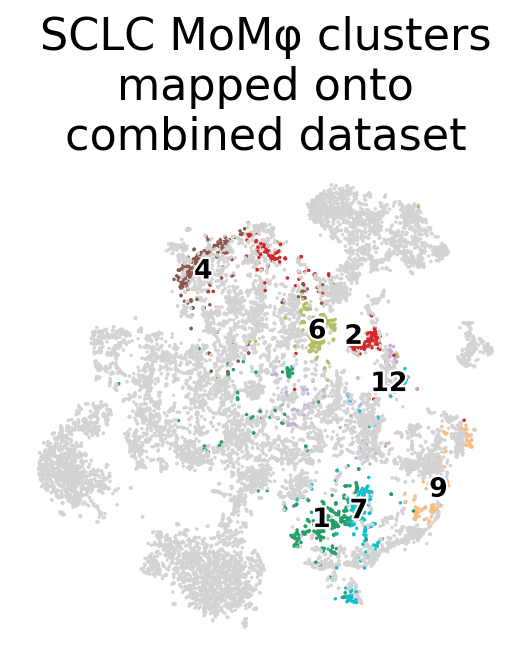

In [48]:
sc.pl.umap(
    adata, 
    color= ['sclc_phenograph'],
    ncols=2, size=10,
    palette = pal,
    legend_loc="on data",
    legend_fontsize=12, vmax = 3,
    legend_fontoutline=2, title = 'SCLC MoMφ clusters\nmapped onto\ncombined dataset' ,
    frameon=False
)

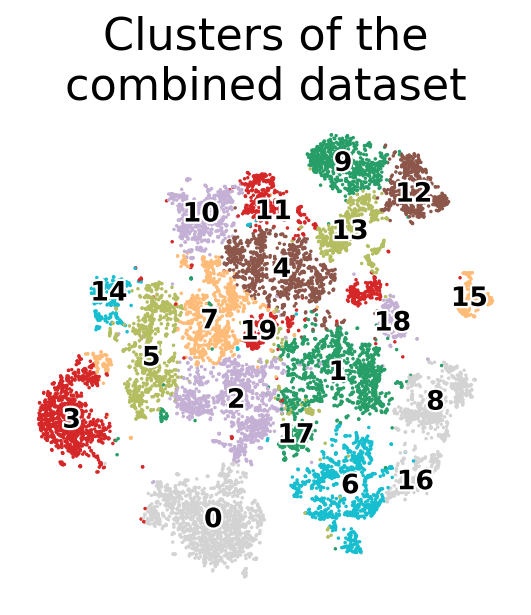

In [49]:
sc.pl.umap(
    adata, 
    color= ['clusters'],
    ncols=2, size=10,
    palette = pal,
    legend_loc="on data",
    legend_fontsize=12, vmax = 3,
    legend_fontoutline=2, title = 'Clusters of the\ncombined dataset',
    frameon=False,
)